In [2]:
import numpy as np
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge, NVAR
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.integrate import solve_ivp
import lyapynov
import nolds
import reservoirpy as rpy
from reservoirpy import verbosity



In [3]:
trajectorys = []
for i in range(100):
    trajectorys.append(np.load("data/rossler0_1Step"+str(i) + ".npy"))

In [4]:
a = b = 0.2
c = 5.7
def Rossler(t, X):
    x, y, z = X
    return [- y - z,
            x + a * y,
            b + z * (x - c)]

In [8]:
train_trajectory  = solve_ivp(Rossler, [0, 1000], 
                    [np.random.uniform(-0.1, 0.1), np.random.uniform(-0.1, 0.1), np.random.uniform(-0.1, 0.1)], 
                    t_eval=np.arange(0, 1000, 0.01), rtol = 1e-11, atol = 1e-11, dense_output=True).y

In [5]:
test_trajectory  = solve_ivp(Rossler, [0, 1000], 
                    [np.random.uniform(-0.1, 0.1), np.random.uniform(-0.1, 0.1), np.random.uniform(-0.1, 0.1)], 
                    t_eval=np.arange(0, 1000, 0.01), rtol = 1e-11, atol = 1e-11, dense_output=True).y

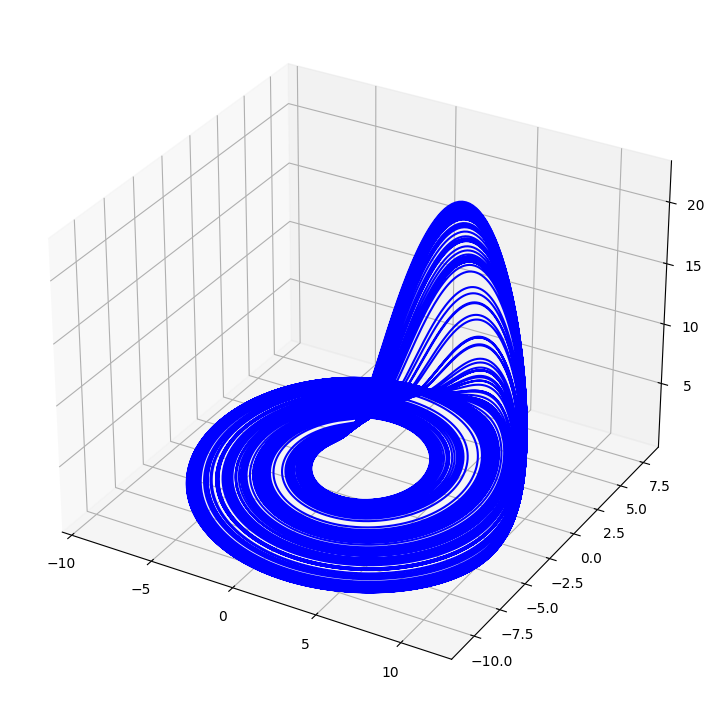

In [35]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(projection='3d')
t_start = 10000
ax.plot(test_trajectory[0][t_start:], test_trajectory[1][t_start:], test_trajectory[2][t_start:], color="blue", label="True values")

In [9]:
# Создаем пользовательский класс Reservoir с методом Рунге-Кутта 4-го порядка
class RK4Reservoir(Reservoir):
    def __init__(self, units, input_gain, W, Win, bias):
        super().__init__(units=units, W=W, Win=Win, bias=bias)
        self.input_gain = input_gain
        self.bias = bias

    def _forward(self, u):
        # Получаем текущее состояние резервуара
        x = self.state()

        # Получаем параметры
        W_in = self.input_weights
        W_res = self.internal_weights
        G = self.input_gain
        B = self.bias

        # Функция динамики резервуара
        def f(x, u):
            return -x + np.tanh(W_res @ x + G * W_in @ u + B)

        # Шаг времени
        dt = 0.1

        # Метод Рунге-Кутта 4-го порядка
        k1 = f(x, u)
        k2 = f(x + 0.5 * dt * k1, u)
        k3 = f(x + 0.5 * dt * k2, u)
        k4 = f(x + dt * k3, u)

        # Обновляем состояние
        x_new = x + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

        # Сохраняем новое состояние
        self.set_state(x_new)

        return x_new

In [93]:
np.random.seed(42)



# Параметры резервуара
# Параметры резервуара
N = 300  # Размер резервуара
bias_p = 3 
G = 0.01 # The strength of the input weights
sparsity = 0.1  # Разреженность 0.1, возможно имелось ввиду 0.9
rho = 0.99 # Спектральный радиус

# Инициализация резервуара
W_res = np.random.uniform(-1, 1, (N, N))
mask = np.random.rand(N, N) < sparsity  # Sparsity mask
W_res *= mask

eigenvalues = np.linalg.eigvals(W_res)
current_rho = np.max(np.abs(eigenvalues))
W_res = (rho / current_rho) * W_res

W_in = np.zeros((N, 3))
for row in range(N):
    column = np.random.randint(0, 3)
    W_in[row][column] = np.random.uniform(-1, 1)

B = np.random.uniform(-bias_p, bias_p, (N, 1)) # Смещение

lr = 1.0  # Параметр утечки (leak rate)


# Создаем резервуар с пользовательским методом обновления


# Параметры эксперимента
theta = .5  # Длина интервала входного сигнала
Tw_solo = 3000  
Tw = 5000 # Время "прогрева" в шагах
record_time = 7500  # Время записи в временных единицах
dt = 0.1
#record_steps = int(record_time / dt)
input_dim = 3  # Размерность входного сигнала

In [102]:
trajectorys[0].shape

(3, 10000)

In [103]:
reservoir = RK4Reservoir(units=N, input_gain=G, W=W_res, Win=W_in, bias=B)

t_start = 1000
input_sequence = trajectorys[0].T[t_start:]#train_trajectory.T[t_start:][::10]
train_record_steps = input_sequence.shape[0] - Tw - 1
target_sequence = input_sequence[Tw+1:]

#Прогрев резервуара без входа
for t in range(Tw_solo):
    reservoir(np.zeros(3))

# Прогрев резервуара
for t in range(Tw):
    for reservoir_step in range(int(theta / dt)):
        reservoir(input_sequence[t])

# Запись состояний резервуара
state_matrix = []
for t in range(Tw, Tw + train_record_steps):
    state = None
    for reservoir_step in range(int(theta / dt)):
        state = reservoir(input_sequence[t])
    #if t % int(theta / dt) == 0:  # Записываем состояние каждые theta временных единиц
    state_matrix.append(np.append(state, 1))  # Добавляем bias term

state_matrix = np.array(state_matrix)

print("State matrix shape:", state_matrix.shape)

State matrix shape: (3999, 301)


In [104]:
readout = Ridge(ridge=1e-7, input_bias=False) 
readout.fit(state_matrix, target_sequence)

'Ridge-11': Ridge(ridge=1e-07, input_bias=False, in=301, out=3)

In [105]:
def ReservoirPredict(tragectory, reservoir):
    reservoir.reset()

    for t in range(Tw_solo):
        reservoir(np.zeros(3))

    # Прогрев резервуара
    for t in range(Tw):
        for reservoir_step in range(int(theta / dt)):
            reservoir(tragectory[t])

    points = []
    point = tragectory[Tw]
    for t in range(Tw, Tw + train_record_steps):
        state = None
        for reservoir_step in range(int(theta / dt)):
            state = reservoir(point)
        new_point = readout(np.append(state, 1))
        points.append(new_point)
        point = new_point
    return np.array(points)

In [106]:
test_trajectory_preds = ReservoirPredict(trajectorys[1].T[t_start:], reservoir)


In [107]:
test_trajectory_preds = test_trajectory_preds[:, 0, :]

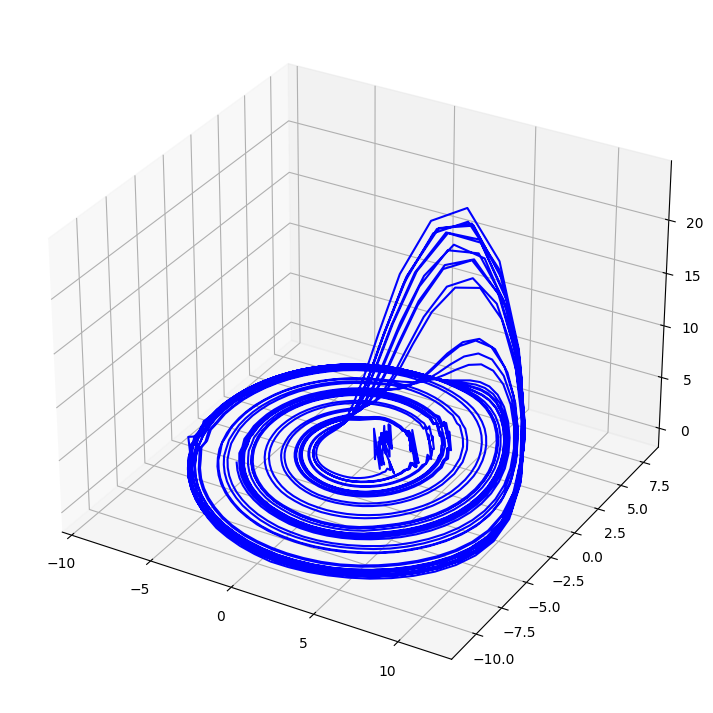

In [108]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(projection='3d')
t_fin = 10000
ax.plot(test_trajectory_preds[:t_fin, 0], test_trajectory_preds[:t_fin, 1], test_trajectory_preds[:t_fin, 2], color="blue")

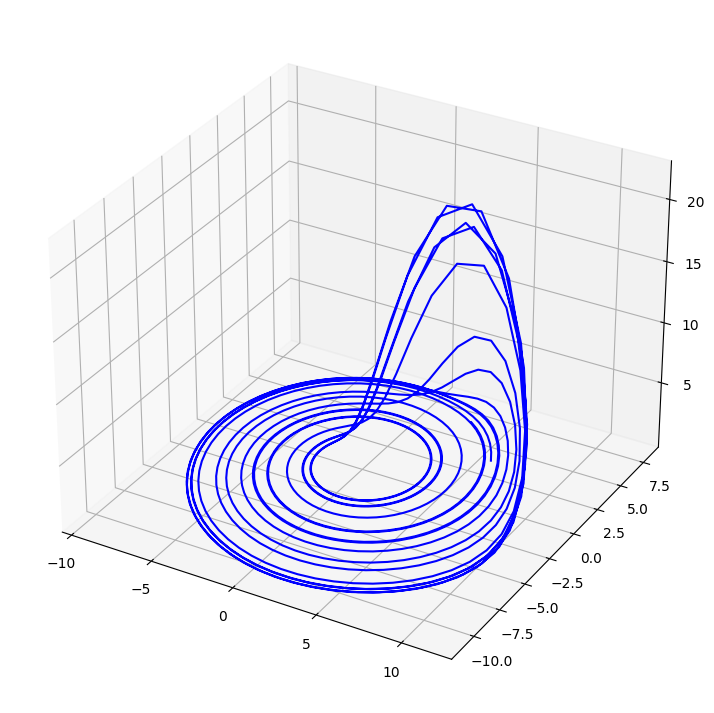

In [69]:

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(projection='3d')
t_fin = 1000
ax.plot(test_trajectory.T[t_start:][::10][:t_fin, 0], test_trajectory.T[t_start:][::10][:t_fin, 1], test_trajectory.T[t_start:][::10][:t_fin, 2], color="blue")